# The "One Common" Dialogue Data

This notebook shows how to import the OneCommon dataset into our common format. (Or, actually, just into pandas dataframes.)

PhotoBook references:
- [on github](https://github.com/Alab-NII/onecommon)
- [the AAAI 2019 paper, Udagawa & Aizawa](https://aaai.org/ojs/index.php/AAAI/article/view/4694)

In [1]:
from __future__ import division
import codecs
import json
import configparser
import os
import sys
import re

from collections import defaultdict, Counter

from time import localtime, strftime

from textwrap import wrap


import pandas as pd
import numpy as np
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, get_image_filename

In [3]:
oc_base = corpora_base + '/onecommon'

In [4]:
with open(oc_base + '/data/final_transcripts.json', 'r') as f:
    tr = json.load(f)

In [5]:
len(tr)

6760

In [6]:
def to_rgb_spec(rgb_in):
    m = re.match(r'rgb\((\d+),(\d+),(\d+)\)', rgb_in)
    rgb = m.groups()
    return list(map(lambda x: x / 255, list(map(int, rgb))))

In [7]:
# after long sleuthing in the code, and after finally remembering that SVG has the origin in the
# top left, this seems to reconstruct the scenes fairly well...
def plt_scene(scene, ax, show_obj_id=False):
    #fig, ax = fax
    #fig, ax = plt.subplots()
    grid_size = 500
    ax.add_artist(plt.Circle((215, 215), 205, fill=False))

    for obj in scene:
        #ax.add_artist(plt.Circle((obj['x'] / grid_size, obj['y'] / grid_size),
        #                         obj['size'] / grid_size, color=to_rgb_spec(obj['color'])))
        ax.add_artist(plt.Circle((obj['x'], 430 - obj['y']),
                                 obj['size'], color=to_rgb_spec(obj['color'])))

        if show_obj_id:
            #ax.text(obj['x'] / grid_size, obj['y'] / grid_size, obj['id'])
            ax.text(obj['x'], 430 - obj['y'], obj['id'])
    ax.set_aspect('equal')
    ax.set_ylim(0,430)
    ax.set_xlim(0,430)
    ax.axis('off')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
def plt_scenes(scenes, show_obj_id=False):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt_scene(scenes[0], ax1, show_obj_id=show_obj_id)
    plt_scene(scenes[1], ax2, show_obj_id=show_obj_id)

In [8]:
def user_styler(r, colmap):
    return ['color: {}'.format(colmap[r['agent']]) for _ in range(len(r))]

def get_colmap(df):
    users = df['agent'].unique().tolist()
    colmap = dict(zip(users, 'blue black'.split()))
    return colmap

def pp(df, width=50, textcol='data'):
    out_cols = []
    for this_col in df.columns:
        textcols = [textcol] if type(textcol) is not list else textcol
        if this_col in textcols:
            out_cols.append(df[this_col]
                            .apply(lambda x: 'XXBREAKHEREXX'.join(wrap(x, width))))
        else:
            out_cols.append(df[this_col])

    display(HTML(pd.concat(out_cols, axis=1)
                 .style.apply(lambda x:
                              user_styler(x,
                                          get_colmap(df)),
                              axis=1)
                 .render()
                 .replace("XXBREAKHEREXX", "<br/>")))

In [9]:
def show_dial(tr):
    plt_scenes(tr['scenario']['kbs'])
    plt_scenes(tr['scenario']['kbs'], show_obj_id=True)
    plt.show()
    this_df = pd.DataFrame(tr['events'])['agent data start_time time'.split()]
    zero_time = float(this_df.iloc[0]['start_time'])
    #this_df['start_time'] = td_reform(pd.to_timedelta(pd.to_numeric(this_df['start_time']) - zero_time))
    this_df['start_time'] = pd.to_numeric(this_df['start_time']) - zero_time
    this_df['time'] = pd.to_numeric(this_df['time']) - zero_time
    
    display(pp(this_df))

In this view, the top left circle shows what agent 0 saw, the top right one what agent 1 saw. The row below gives the numerical IDs for the circles, so that the final selection action in the dialogue transcript can be evaluated.

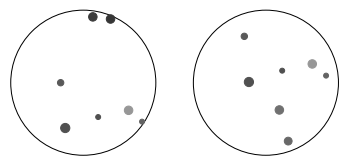

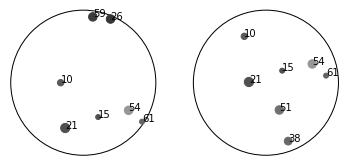

,agent,data,start_time,time
0,0,"I have two dark twins, very close to each other,and large.",0,11.99
1,1,"I don't see those. I have one light grey one,small darker grey below it to the right?",20.05,68.93
2,0,"I see those, I think. There is another small darkone to the lower left of the big light one?",84.12,106.3
3,1,"Yes, further away.",118.83,121.22
4,0,Yes! Let's go with the large light colored one!,125.12,134.41
5,1,Good.,137.79,138.72
6,0,54,nan,139.65
7,1,54,nan,140.16


None

In [10]:
show_dial(tr[20])